# Chapter 6: The Many Variables & The Spurious Waffles - Exercises

In [48]:
from matplotlib import pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel
import daft
from rethinking import DATA_PATH, standardize, precis
import pandas as pd
import pymc as pm
import numpy as np
from scipy import stats

**5E1** Which of the linear models below are multiple linear regressions?

1. $\mu_i = \alpha + \beta x_i$
2. $\mu_i = \beta_xx_i + \beta_zz_i$
3. $\mu_i = \alpha + \beta(x_i - z_i)$
4. $\mu_i = \alpha + \beta_xx_i + \beta_zz_i$

Answer:

(2) and (4)

**5E2** Write down a multiple regression to evaluate the claim: *Animal diversity is linearly related to latitude, but only after controlling for plant diversity*. You just need to write down the model definition.

Answer:

$D_{a[i]}= \alpha + \beta_{L}L_{[i]} - \beta_{D_p}D_{p[i]}$

**5E3** Write down a multiple regression to evaluate the claim: *Neither amount of funding nor size of laboratory is by itself a good predictor of time to PhD degree; but together these variables are both positively associated with time to degree*. Write down the model definition and indicate which side of zero each slope parameter should be on.

Answer:

$\text{PhD}_i = \alpha + \beta_FF_i + \beta_SS_i$

$\beta_F, \beta_S >0$

**5E4** Suppose you have a single categorical predictor with 4 levels (unique values), labeled $A$, $B$, $C$ and $D$. Let $A_i$ be an indicator variable that is 1 where case $i$ is in category $A$. Also suppose $B_i$, $C_i$, and $D_i$ for the other categories. Now which of the following linear models are inferentially equivalent ways to include the categorical variable in a regression? Models are inferentially equivalent when it’s possible to compute one posterior distribution from the posterior distribution of another model.

1. $\mu_i = \alpha + \beta_AA_i + \beta_BB_i + \beta_DD_i$
2. $\mu_i = \alpha + \beta_AA_i + \beta_BB_i + \beta_CC_i + \beta_DD_i$
3. $\mu_i = \alpha + \beta_BB_i + \beta_CC_i + \beta_DD_i$
4. $\mu_i = \alpha_AA_i + \alpha_BB_i + \alpha_CC_i + \alpha_DD_i$
5. $\mu_i = \alpha_A(1 - B_i - C_i - D_i) + \alpha_BB_i + \alpha_CC_i + \alpha_DD_i$

Answer:

(1), (3), (4) and (5) are inferentially equivalent. (2) has one extra parameter.

**5M1** Invent your own example of a spurious correlation. An outcome variable should be correlated with both predictor variables. But when both predictors are entered in the same model, the correlation between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced)

Answer:

If we have a predictor A that influences variable B and O, both B and O will be correlated. But, outcome O will actually be directly related to A.

Let's consider an actual scenario. I am investigating the source of my stomach pain, and I have data on quantity of food I ate, and the amount of dirty dishes I had after eating. There is a positive relationship between the pain and amount of dirty dishes, but that is just because dirty dishes is also directly related to the amounf of food I ate, the actual cause of my stomach pain. Therefore there is a conditional independence on dirty dishes.

[('O', 'B', {'A'})]


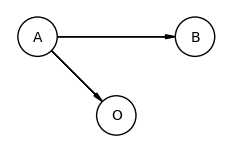

In [17]:
dag = CausalGraphicalModel(nodes=['A', 'O', 'B'], edges=[('A', 'O'), ('A', 'B')])
pgm = daft.PGM()
coordinates = {'A': (0, 0), 'O': (1, 1), 'B': (2, 0)}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

print(dag.get_all_independence_relationships())

**5M2** Invent your own example of a masked relationship. An outcome variable should be correlated with both predictor variables, but in opposite directions. And the two predictor variables should be correlated with one another.

Answer:

In this scenario, B and A have an opposite relationship with O, and in a multiple regression, they will nulify their influence.

[]


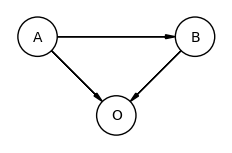

In [15]:
dag = CausalGraphicalModel(nodes=['A', 'O', 'B'], edges=[('A', 'O'), ('A', 'B'), ('B', 'O')])
pgm = daft.PGM()
coordinates = {'A': (0, 0), 'O': (1, 1), 'B': (2, 0)}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

print(dag.get_all_independence_relationships())

**5M3** It is sometimes observed that the best predictor of fire risk is the presence of firefighters — States and localities with many firefighters also have more fires. Presumably firefighters do not cause fires. Nevertheless, this is not a spurious correlation. Instead fires cause firefighters. Consider the same reversal of causal inference in the context of the divorce and marriage data. How might a high divorce rate cause a higher marriage rate? Can you think of a way to evaluate this relationship, using multiple regression?

Answer:

Suppose that people that have divorced, are more prone to get marries, therefore, increasing divorce rate could lead to more marriages. Since we only have two variables here, and the only question we have is the direction of the interaction, we can only solve this through scientific reasoning.

**5M4** In the divorce data, States with high numbers of members of the Church of Jesus Christ of Latter-day Saints (LDS) have much lower divorce rates than the regression models expected. Find a list of LDS population by State and use those numbers as a predictor variable, predicting divorce rate using marriage rate, median age at marriage, and percent LDS population (possibly standardized). You may want to consider transformations of the raw percent LDS variable.

In [33]:
waffle = pd.read_csv(DATA_PATH.joinpath('WaffleDivorce.csv'), sep=';')
lds = pd.read_csv(DATA_PATH.joinpath('lds.csv'), sep=',')
lds.head()

,State,Membership,Population,LDS,Temples,Missions,Districts,Stakes,Wards,Branches,Congregations,Family History Centers
0,Alabama,"37,765","4,903,185",0.77%,1,1,0,8,48,28,76,44
1,Alaska,"33,495","731,545",4.58%,1,1,0,8,59,21,80,15
2,Arizona,"436,521","7,278,717",6.00%,6,6,0,115,842,84,926,74
3,Arkansas,"32,307","3,017,804",1.07%,0,2,0,7,46,23,69,25
4,California,"756,507","39,512,223",1.91%,7,15,0,153,"1,092",137,"1,229",228


In [65]:
lds['L'] = lds['LDS'].str.extract('(.*)%').astype(float)
data = waffle.merge(lds[['State', 'L']], left_on='Location', right_on='State')
L = standardize(data['L']).values
A = standardize(data['MedianAgeMarriage']).values
M = standardize(data['Marriage']).values
oD = data['Divorce'].values

In [49]:
# Fit the multivariate model
with pm.Model() as model:
    a = pm.Normal('A', 0, 1)  # prior on alpha
    bM = pm.Normal('bM', 0, 0.5)  # prior on beta_M
    bA = pm.Normal('bA', 0, 0.5)  # prior on beta_A
    bL = pm.Normal('bL', 0, 0.5)  # prior on beta_L
    sigma = pm.Exponential('sigma', lam=1)  # prior on sigma
    mu = a + bM * M + bA * A + bL * L
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=oD)  # likelihood of the data

# Extract the variable names
vars_ = [a, bM, bA, bL, sigma]
var_names = [v.name for v in vars_]

mean_q = pm.find_MAP(model=model)
H = pm.find_hessian(mean_q, vars_, model=model)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[var_]) for var_ in var_names])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

post_data = pd.DataFrame(posterior.rvs(10_000), columns=var_names)

precis(posterior, var_names)

,mean,std,5.5%,94.5%
A,9.325030,0.206443,8.996423,9.655410
bM,0.149413,0.246077,-0.246585,0.536158
bA,-1.037759,0.243923,-1.434213,-0.651102
bL,-0.462345,0.213543,-0.802346,-0.125971
sigma,1.390667,0.108455,1.217925,1.564035


The posterior corroborates the claim the states with higher LDS proportions have lower divorce rates. $\beta_L$ PI excludes the null value from being plausible when considering all of these factors.

**5M5** One way to reason through multiple causation hypotheses is to imagine detailed mechanisms through which predictor variables may influence outcomes. For example, it is sometimes argued that the price of gasoline (predictor variable) is positively associated with lower obesity rates (outcome variable). However, there are at least two important mechanisms by which the price of gas could reduce obesity. First, it could lead to less driving and therefore more exercise. Second, it could lead to less driving, which leads to less eating out, which leads to less consumption of huge restaurant meals. Can you outline one or more multiple regressions that address these two mechanisms? Assume you can have any predictor data you need.

Answer:

Let's consider the variables

$$
\begin{aligned}
P &= \text{Price of Gas} \\
O &= \text{Obesity} \\
D &= \text{Driving} \\
M &= \text{Meals Out} \\
E &= \text{Exercising} \\
\end{aligned}
$$

Now we can consider these relationships.

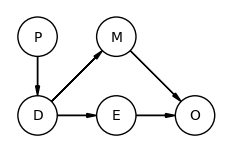

In [55]:
dag = CausalGraphicalModel(nodes=['P', 'O', 'D', 'M', 'E'], edges=[('P', 'D'), ('D', 'M'), ('D', 'E'), ('E', 'O'), ('M', 'O')])
pgm = daft.PGM()
coordinates = {'P': (0, 0), 'O': (2, 1), 'D': (0, 1), 'M': (1, 0), 'E': (1, 1)}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

**5H1** In the divorce example, suppose the DAG is: M → A → D. What are the implied conditional independencies of the graph? Are the data consistent with it?

Conditional Independencies:  [('M', 'D', {'A'})]


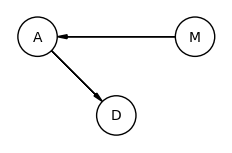

In [62]:
dag = CausalGraphicalModel(nodes=['M', 'A', 'D'], edges=[('M', 'A'), ('A', 'D')])
pgm = daft.PGM()
coordinates = {'A': (0, 0), 'D': (1, 1), 'M': (2, 0)}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

print('Conditional Independencies: ', dag.get_all_independence_relationships())

In [61]:
# Fit the multivariate model
with pm.Model() as model:
    a = pm.Normal('A', 0, 1)  # prior on alpha
    bM = pm.Normal('bM', 0, 0.5)  # prior on beta_M
    bA = pm.Normal('bA', 0, 0.5)  # prior on beta_A
    sigma = pm.Exponential('sigma', 1)  # prior on sigma
    mu = a + bM * M + bA * A
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=oD)  # likelihood of the data

# Extract the variable names
vars_ = [a, bM, bA, sigma]
var_names = [v.name for v in vars_]

mean_q = pm.find_MAP(model=model)
H = pm.find_hessian(mean_q, vars_, model=model)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[var_]) for var_ in var_names])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

post_data = pd.DataFrame(posterior.rvs(10_000), columns=var_names)

precis(posterior, var_names)

,mean,std,5.5%,94.5%
A,9.271427,0.223698,8.917748,9.629607
bM,0.017621,0.249773,-0.378263,0.424072
bA,-0.909184,0.255211,-1.316844,-0.496820
sigma,1.493979,0.106426,1.323747,1.661397


As can be seen from the distribution summary we have $\beta_M$ with possible no influence in a multiple regression, when $\beta_A$ is included. We already know that there is a correlation between $M$ and $D$, therefore this is equivalent to saying that $D$ is conditionally independent of $M$ on $A$.

**5M2** Assuming that the DAG for the divorce example is indeed M → A → D, fit a new model and use it to estimate the counterfactual effect of halving a State’s marriage rate M. Using the counterfactual example from the chapter (starting on page 140) as a template.

To start, we need to do the two required models for this association.

In [72]:
# Fit the multivariate model
with pm.Model() as model:
    a = pm.Normal('a', 0, 1)  # prior on alpha
    bM = pm.Normal('bM', 0, 0.5)  # prior on beta_M
    sigma = pm.Exponential('sigma', 1)  # prior on sigma
    mu = a + bM * M
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=A)  # likelihood of the data

# Extract the variable names
vars_ = [a, bM, sigma]
var_names = [v.name for v in vars_]

mean_q = pm.find_MAP(model=model)
H = pm.find_hessian(mean_q, vars_, model=model)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[var_]) for var_ in var_names])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

post_data_M = pd.DataFrame(posterior.rvs(10_000), columns=var_names)

precis(posterior, var_names)

,mean,std,5.5%,94.5%
a,0.001479,0.096310,-0.151606,0.154959
bM,-0.696415,0.096187,-0.848760,-0.540217
sigma,0.682080,0.099323,0.520670,0.840407


In [73]:
# Fit the multivariate model
with pm.Model() as model:
    a = pm.Normal('a', 0, 1)  # prior on alpha
    bA = pm.Normal('bA', 0, 0.5)  # prior on beta_A
    sigma = pm.Exponential('sigma', 1)  # prior on sigma
    mu = a + bA * A
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=oD)  # likelihood of the data

# Extract the variable names
vars_ = [a, bA, sigma]
var_names = [v.name for v in vars_]

mean_q = pm.find_MAP(model=model)
H = pm.find_hessian(mean_q, vars_, model=model)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[var_]) for var_ in var_names])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

post_data_A = pd.DataFrame(posterior.rvs(10_000), columns=var_names)

precis(posterior, var_names)

,mean,std,5.5%,94.5%
a,9.276884,0.221829,8.917739,9.632735
bA,-0.922763,0.199013,-1.240767,-0.601523
sigma,1.489712,0.105879,1.319569,1.657632


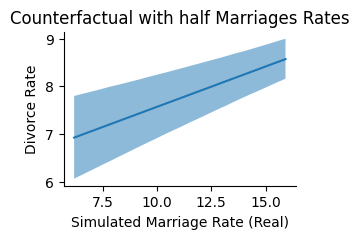

In [97]:
# Halving the states marriage rates
M_halved = (
    ((data['Marriage'] / 2) - data['Marriage'].mean())
    / data['Marriage'].std()
)
M_sim = np.linspace(M_halved.min() - 0.15, M_halved.max() + 0.15, 30)

A_sim = (
    post_data_M[['a']].to_numpy()
    + post_data_M[['bM']].to_numpy() * np.tile(M_sim, (10_000, 1))
).mean(axis=0)

mu = (
    post_data_A[['a']].to_numpy()
    + post_data_A[['bA']].to_numpy() * np.tile(A_sim, (10_000, 1))
)
mu_mean = mu.mean(axis=0)
mu_PI = np.array([np.quantile(m, [0.055, 0.945]) for m in mu.T])

M_real = M_sim * data['Marriage'].std() + data['Marriage'].mean()

# Plotting
plt.figure(figsize=(3, 2))
ax = plt.subplot()
plt.plot(M_real, mu_mean)
plt.fill_between(M_real, mu_PI[:, 0], mu_PI[:, 1], alpha=0.5)
plt.title('Counterfactual with half Marriages Rates')
plt.xlabel('Simulated Marriage Rate (Real)')
plt.ylabel('Divorce Rate')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False);

**5H3** Return to the milk energy model, m5.7. Suppose that the true causal relationship among the variables is:

M → N → K    
M → K

Now compute the counterfactual effect on K of doubling M. You will need to account for both the direct and indirect paths of causation. Use the counterfactual example from the chapter (starting on page 140) as a template.

In [105]:
d = pd.read_csv(DATA_PATH.joinpath('milk.csv'), sep=';')
d = d.dropna(subset=['kcal.per.g', 'neocortex.perc', 'mass'], how='any')
Ko = standardize(d['kcal.per.g']).values
N = standardize(d['neocortex.perc']).values
M = standardize(np.log(d['mass'])).values

In [106]:
with pm.Model() as model_M_N:
    a = pm.Normal('a', 0, 1)  # prior on alpha
    bM = pm.Normal('bM', 0, 0.5)  # prior on beta_M
    sigma = pm.Exponential('sigma', 1)  # prior on sigma
    mu = a + bM * M
    N = pm.Normal('N', mu=mu, sigma=sigma, observed=N)  # likelihood of the data
    
# Extract the variable names
vars_ = [a, bM, sigma]
var_names = [v.name for v in vars_]

mean_q = pm.find_MAP(model=model_M_N)
H = pm.find_hessian(mean_q, vars_, model=model_M_N)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[var_]) for var_ in var_names])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

post_data_N = pd.DataFrame(posterior.rvs(10_000), columns=var_names)

precis(posterior, var_names)

,mean,std,5.5%,94.5%
a,0.000847,0.151999,-0.242160,0.246507
bM,0.679744,0.151797,0.440496,0.923408
sigma,0.632761,0.166570,0.367160,0.896122


In [108]:
with pm.Model() as model_K:
    a = pm.Normal('a', 0, 1)  # prior on alpha
    bM = pm.Normal('bM', 0, 0.5)  # prior on beta_M
    bN = pm.Normal('bN', 0, 0.5) # prior on beta_N
    sigma = pm.Exponential('sigma', 1)  # prior on sigma
    mu = a + bM * M + bN * N
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=Ko)  # likelihood of the data
    
# Extract the variable names
vars_ = [a, bM, bN, sigma]
var_names = [v.name for v in vars_]

mean_q = pm.find_MAP(model=model_K)
H = pm.find_hessian(mean_q, vars_, model=model_K)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[var_]) for var_ in var_names])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

post_data_K = pd.DataFrame(posterior.rvs(10_000), columns=var_names)

precis(posterior, var_names)

,mean,std,5.5%,94.5%
a,0.001418,0.164866,-0.262647,0.264957
bM,-0.742928,0.233220,-1.109469,-0.367966
bN,0.637072,0.232522,0.261986,1.006513
sigma,0.690616,0.178090,0.405007,0.975208


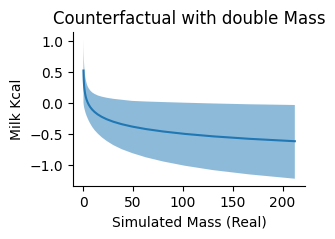

In [111]:
# Doubling Mass
M_doubled = (
    (np.log(d['mass'] * 2) - np.log(d['mass']).mean())
    / np.log(d['mass']).std()
)
M_sim = np.linspace(M_doubled.min() - 0.15, M_doubled.max() + 0.15, 30)

N_sim = (
    post_data_N[['a']].to_numpy()
    + post_data_N[['bM']].to_numpy() * np.tile(M_sim, (10_000, 1))
).mean(axis=0)

mu = (
    post_data_K[['a']].to_numpy()
    + post_data_K[['bM']].to_numpy() * np.tile(M_sim, (10_000, 1))
    + post_data_K[['bN']].to_numpy() * np.tile(N_sim, (10_000, 1))
)
mu_mean = mu.mean(axis=0)
mu_PI = np.array([np.quantile(m, [0.055, 0.945]) for m in mu.T])

M_real = np.exp(M_sim * np.log(d['mass']).std() + np.log(d['mass']).mean())

# Plotting
plt.figure(figsize=(3, 2))
ax = plt.subplot()
plt.plot(M_real, mu_mean)
plt.fill_between(M_real, mu_PI[:, 0], mu_PI[:, 1], alpha=0.5)
plt.title('Counterfactual with double Mass')
plt.xlabel('Simulated Mass (Real)')
plt.ylabel('Milk Kcal')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False);

**5H4** Here is an open practice problem to engage your imagination. In the divorce data, States in the southern United States have many of the highest divorce rates. Add the `South` indicator variable to the analysis. First, draw one or more DAGs that represent your ideas for how Southern American culture might influence any of the other three variables (D, M, or A). Then list the testable implications of your DAGs, if there are any, and fit one or more models to evaluate the implications. What do you think the influence of “Southerness” is?